In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadDateSet(filename):
    dataMat = []
    fr = open(filename)
    for line in fr.readlines():
        # strip()移除首位空格
        curline = line.strip().split('\t')
        # map(func, iter) py3返回迭代器， py2返回列表
        fltLine = list(map(lambda x: float(x), curline))
        dataMat.append(fltLine)
    return dataMat

In [3]:
def distEclud(vecA, vecB):
    # 对应元素相减，对应元素平方
    # print(np.power(vecA-vecB, 2))
    return np.sqrt(sum(np.power(vecA-vecB, 2)))

In [4]:
def randCent(dataSet, k):
    n = dataSet.shape[1]
    print(dataSet.shape, n)
    # k个质心， 特征数为n, 为矩阵类型，可以直接centroids[:, j] = 1 + np.random.rand(k,1)
    # 如果是np.array(), 报错 (2,) 不能赋值(2,1)
    centroids = np.mat(np.zeros(shape=(k,n)))
    for j in range(n):
        minJ = min(dataSet[:,j])   # 特征J那一列最小值
        rangeJ = float(max(dataSet[:, j]) - minJ)  # 最大值-最小值
        centroids[:, j] = minJ + rangeJ * np.random.rand(k,1) # 最小值 + (最大值-最小值)* rand(k,1) # rand(k,1)就是shape=(2,1)的随机数
    return centroids

In [5]:
def Kmeans(dataSet, k, distMeans=distEclud, createCent=randCent):
    m = dataSet.shape[0]
    centroids = np.array(createCent(dataSet=dataSet, k=k))   # 随机质心
    
    clusterAssment = np.array(np.zeros((m,2)))       # 每个样本与质心的信息，[某个质心， 与该质心的距离]
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):   # 遍历每一个样本和每个质心，找出距离样本最近的质心
            minDist = np.inf; minIndex = -1
            for j in range(k):
                distJI = distMeans(dataSet[i,:], centroids[j,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
                    
            if clusterAssment[i,0] != minIndex:
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist**2
        print(centroids)
    
        for cent in range(k):   # 更新质心
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0] == cent)[0]]    # 第 cent 类的挑选出来
            centroids[cent, :] = np.mean(ptsInClust, axis=0)   # 按列求均值axis = 0
    
    return centroids, clusterAssment

In [6]:
datMat = np.array(loadDateSet('testSet2.txt'))

In [7]:
myCentroids, clustAssing = Kmeans(dataSet=datMat, k=3, distMeans=distEclud, createCent=randCent)

(60, 2) 2
[[-4.62782924  2.80346226]
 [ 0.56295164 -0.01713504]
 [-1.57764233 -1.37853437]]
[[-3.06779095  3.33769884]
 [ 2.76275171  3.12704005]
 [-0.45965615 -2.7782156 ]]
[[-2.94737575  3.3263781 ]
 [ 2.93386365  3.12782785]
 [-0.45965615 -2.7782156 ]]


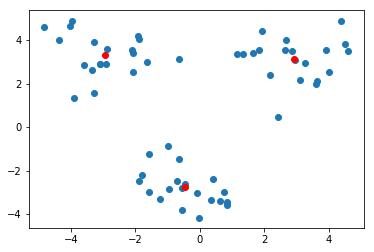

In [8]:
x, y = datMat[:, 0], datMat[:, 1]
cenx, ceny = myCentroids[:, 0], myCentroids[:,1]
plt.scatter(x,y)
plt.scatter(cenx, ceny, c='red')

In [9]:
def biKmeans(dataSet, k, distMeas = distEclud):
    m = dataSet.shape[0]
    clusterAssment = np.zeros((m,2))
    centroid0 = np.mean(dataSet, axis=0)
    centList = [centroid0]
    print(centroid0)
    for j in range(m):
        clusterAssment[j, 1] = distMeas(dataSet[j,:], centroid0)**2
    
    while len(centList) < k:
        lowestSSE = -np.inf
        for i in range(len(centList)):   # 尝试划分每个质点的簇
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:, 0]==i)[0], :]   # 筛选出属于那个质点的所有点（的行）
            centroidMat, splitClustAss = Kmeans(dataSet=ptsInCurrCluster, k=2, distMeans=distMeas)  # 将其划分为两个部分
            sseSplit = np.sum(splitClustAss[:,1])   # 划分后的子集的距离求和
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:, 0]==i)[0], 1])  # 没划分的样本信息后面的dist求和
            print(sseSplit, sseNotSplit)
            if sseNotSplit - sseSplit > lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                lowestSSE = sseNotSplit - sseSplit
                bestClustAss = splitClustAss.copy()
        bestClustAss[np.nonzero(bestClustAss[:, 0]==1)[0], 0] = len(centList)     # 新的簇号
#         bestClustAss[np.nonzero(bestClustAss[:, 0]==0)[0], 0] = bestCentToSplit  # 要划分的簇号，不变即可
        
        centList[bestCentToSplit] = bestNewCents[0,:]  # 要划分的质新，更新一个
        centList.append(bestNewCents[1,:])             # 二分带来的新的一个质心
        clusterAssment[np.nonzero(clusterAssment[:, 0]==bestCentToSplit)[0], :] = bestClustAss  # 原本属于该簇心的样本信息的更新
    
    return centList, clusterAssment

In [10]:
centList, myNewAssments = biKmeans(dataSet=datMat, k=3, distMeas=distEclud)

[-0.15772275  1.22533012]
(60, 2) 2
[[-2.95165989  3.93862186]
 [ 1.82775345 -3.73060211]]
[[-0.48729809  3.42433234]
 [ 0.30368272 -1.853273  ]]
[[-0.06953469  3.29844341]
 [-0.32150057 -2.62473743]]
[[-0.00675605  3.22710297]
 [-0.45965615 -2.7782156 ]]
453.0334895807502 936.6197520850175
(40, 2) 2
[[-3.34147012  4.41756935]
 [-4.56907135  2.20024212]]
[[ 0.38490422  3.35338275]
 [-3.5316985   2.090585  ]]
[[ 2.19136054  3.20239754]
 [-3.30393094  3.26416112]]
[[ 2.93386365  3.12782785]
 [-2.94737575  3.3263781 ]]
77.59224931775066 423.8762401366249
(20, 2) 2
[[ 0.21392806 -1.10520555]
 [-0.94194339 -1.60438877]]
[[ 0.7034562  -3.1662018 ]
 [-0.84736027 -2.64888687]]
[[ 0.46927663 -3.30031012]
 [-1.07894467 -2.43015258]]
[[ 0.35496167 -3.36033556]
 [-1.12616164 -2.30193564]]
12.753263136887313 29.15724944412535


In [11]:
centList

[array([2.93386365, 3.12782785]),
 array([-0.45965615, -2.7782156 ]),
 array([-2.94737575,  3.3263781 ])]

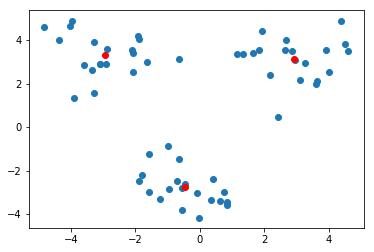

In [12]:
x, y = datMat[:, 0], datMat[:, 1]
cenx = [x[0] for x in centList]
ceny = [x[1] for x in centList]
plt.scatter(x,y)
plt.scatter(cenx, ceny, c='red')